In [129]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

#system lib
import os
import json
from importlib import reload
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

# 3rd party lib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib auto

# astro lib
from astropy.io import fits

# my lib
import ImageTools as it
import DataTools as dt
import gphelper
from gphelper import GPHelper

Using matplotlib backend: Qt5Agg


In [58]:
gp_h = GPHelper(restore_file='gp.json')
gp_j = GPHelper(restore_file='gp_j.json')
gp_v = GPHelper(restore_file='gp_v.json')
gp_z = GPHelper(restore_file='gp_z.json')

In [ ]:
rp_ip = []
with open('rp_ip', 'r') as f:
    for line in f:
        rp_ip.append(line.strip())


In [114]:
r_limit = 5

# draw a sample
rpip = np.random.choice(rp_ip)
rpip = rpip.split(',')
rp, ip = float(rpip[0]), float(rpip[1])

y, x = np.meshgrid(np.arange(84), np.arange(84))
cx, cy = 41.5, 41.25
rs = np.sqrt((x-cx)**2 + (y-cy)**2) 
norm_rs = rs / rp
img = norm_rs.copy()

sorted_rs = np.array(sorted(np.unique(img)))
fs = 10**gp_h.sample(sorted_rs[sorted_rs<=r_limit,np.newaxis]) * ip

for r in sorted_rs:
    if r <= r_limit:
        img[img==r] = fs[sorted_rs[sorted_rs<=r_limit]==r, 0]
    else:
        img[img==r] = 0

plt.imshow(img)

In [117]:
plt.imshow(img)

In [116]:
# get color ratio
color_rs = np.array(sorted(np.unique(rs[norm_rs<=5])))

j_vals = gp_j.predict(color_rs[:,np.newaxis])
v_vals = gp_v.predict(color_rs[:,np.newaxis])
z_vals = gp_z.predict(color_rs[:,np.newaxis])

j_ratio = rs.copy()
v_ratio = rs.copy()
z_ratio = rs.copy()

for r in color_rs:
    if r <= pixel_bound:
        j_ratio[rs==r] = j_vals[color_rs==r]
        v_ratio[rs==r] = v_vals[color_rs==r]
        z_ratio[rs==r] = z_vals[color_rs==r]
    else:
        j_ratio[rs==r] = 1.0
        v_ratio[rs==r] = 1.0
        z_ratio[rs==r] = 1.0

j_img = j_ratio * img     
v_img = v_ratio * img
z_img = z_ratio * img

plt.figure()
plt.imshow(j_img)
plt.figure()
plt.imshow(v_img)
plt.figure()
plt.imshow(z_img)

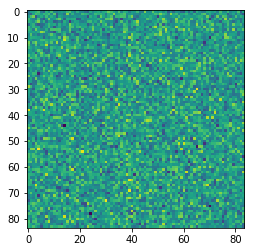

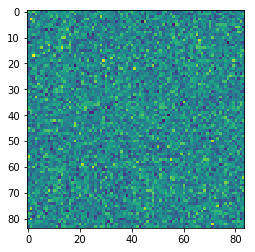

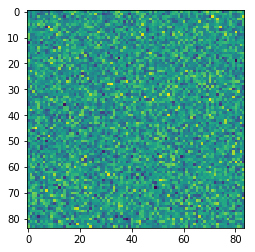

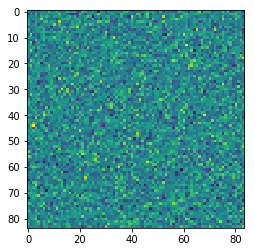

In [125]:
# get noise
noise_params = []
with open('signal_to_noise', 'r') as f:
    for line in f:
        #noise_params.append(tuple(float(i) for i in line.strip().split(',')))
        noise_params.append(line.strip())

h_mean, h_std, h_snr, j_mean, j_std, j_snr, v_mean, v_std, v_snr, z_mean, z_std, z_snr = tuple(float(i) for i in np.random.choice(noise_params).split(','))
h_noise = np.random.normal(loc=h_mean, scale=h_std, size=[84,84])
j_noise = np.random.normal(loc=j_mean, scale=j_std, size=[84,84])
v_noise = np.random.normal(loc=v_mean, scale=v_std, size=[84,84])
z_noise = np.random.normal(loc=z_mean, scale=z_std, size=[84,84])

plt.figure()
plt.imshow(h_noise)
plt.figure()
plt.imshow(j_noise)
plt.figure()
plt.imshow(v_noise)
plt.figure()
plt.imshow(z_noise)

In [105]:
i = img[norm_rs<=10].mean()
n = h_noise.mean()
rat = h_snr*n/i
scaled = h_noise/rat
i_with_noise = img.copy()
i_with_noise[norm_rs>5] = scaled[norm_rs>5]

print(h_snr)
print(i, n)
print(rat)
print(scaled.mean())
print(i/scaled.mean())
print((i_with_noise[norm_rs<=5].mean()/scaled.mean()))



133.154
0.00183435940928 0.00020495915601
14.8777449617
1.37762245916e-05
133.154
133.154


In [132]:
# adjust snr to a measured level
rms = lambda a: np.sqrt(np.mean(np.square(a)))
def get_scaled_noise(img, noise, goal, img_mask):
    i = img[img_mask].sum()
    n = rms(noise)
    ratio = goal*n/i
    scaled = noise/ratio
    img_with_noise = img.copy()
    #img_with_noise[~img_mask] = scaled[~img_mask]
    img_with_noise += scaled
    print(goal, img_with_noise[img_mask].sum()/rms(scaled))
    return img_with_noise


img_mask = (norm_rs<=5)

plt.figure()
plt.title('H')
plt.imshow(get_scaled_noise(img, h_noise, h_snr, img_mask))
plt.figure()
plt.title('J')
plt.imshow(get_scaled_noise(j_img, j_noise, j_snr, img_mask))
plt.figure()
plt.title('V')
plt.imshow(get_scaled_noise(v_img, v_noise, v_snr, img_mask))
plt.figure()
plt.title('Z')
plt.imshow(get_scaled_noise(z_img, z_noise, z_snr, img_mask))


3759.02 4202.73188066
2979.41 3198.68729463
443.025 1537.96155119
761.884 2387.81614139


`rp` = Draw from the distribution of measured Petrosian Radii

`ip` = Draw from the distribution of measured $I(Rp)$

`rs` = a matrix of r-values from a center value (41.5, 41.25)

`normed_rs` =  `rs/rp`

Steps:
 1. Get the x values for the Gaussian process
  - x = all unique `normed_rs` less than or equal to 5
 1. y = draw from the gaussian process using values from x
 1. Set values in an 84x84 image based by mapping pixels to a `normed_rs` value, which looks like

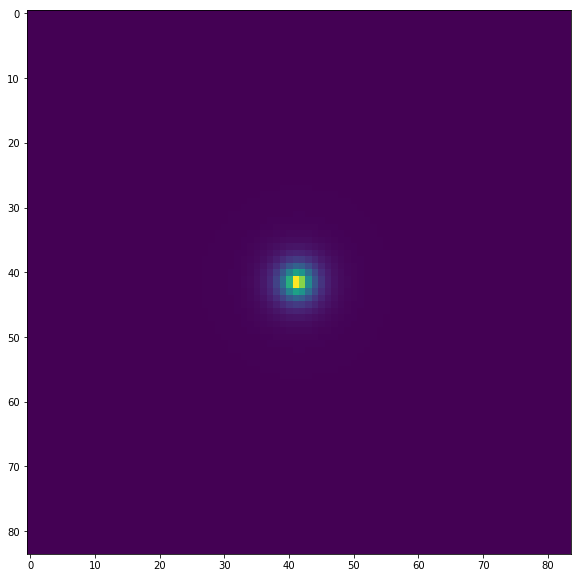

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(img)

Get noise to fill the image